In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM, EigenCAM, EigenGradCAM, FullGrad, ScoreCAM, AblationCAM, XGradCAM, HiResCAM
from transformers import AutoImageProcessor, ResNetForImageClassification, AutoModel
import matplotlib.pyplot as plt

Getting `pytorch-grad-cam` to work with HuggingFace models. The first half is ResNet, then I use ViTs (DINO and google-vit)

In [2]:
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = model
        # self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
        self.feature_extractor = model

    def forward(self, x):
        return self.feature_extractor(x)['pooler_output'][:, :, 0, 0]

resnet = AutoModel.from_pretrained("microsoft/resnet-50")
processor = AutoImageProcessor.from_pretrained(
    "microsoft/resnet-50",
    use_fast=True,
    do_resize=True,
    size={'shortest_edge': 400},
    do_center_crop=False
)

model = ResnetFeatureExtractor(resnet)
model.eval()

# util function
def center_crop(img, crop_width=None):
    '''
    center crop a PIL image to be square
    '''
    w, h = img.size

    if crop_width is None:
        crop_width = min(h,w)

    if crop_width > w:
        raise ValueError("Crop size must be less than or equal to image size")

    left = (w - crop_width) // 2
    top = (h - crop_width) // 2
    right = left + crop_width
    bottom = top + crop_width

    return img.crop((left, top, right, bottom))

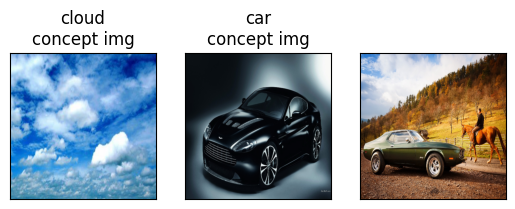

In [3]:
car_img = center_crop(Image.open('/home/ronan/Pictures/Saved Pictures/car.png').convert("RGB"))
cloud_img = center_crop(Image.open('/home/ronan/Pictures/Saved Pictures/clouds.png').convert("RGB"))
car_horse_img = center_crop(Image.open('/home/ronan/Pictures/Saved Pictures/car_and_horse.png').convert("RGB"))

car_input = processor(car_img, return_tensors='pt')
cloud_input = processor(cloud_img, return_tensors='pt')
car_horse_input = processor(car_horse_img, return_tensors='pt')

car_concept_features = model(car_input['pixel_values'])[0]
cloud_concept_features = model(cloud_input['pixel_values'])[0]

fig, axs = plt.subplots(ncols=3)
for img, ax in zip([cloud_img, car_img, car_horse_img], axs):
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

axs[0].set_title("cloud\nconcept img")
axs[1].set_title("car\nconcept img")
plt.show()

here loss=tensor(1.0018, grad_fn=<AddBackward0>)
reverse hook activating, type(grad)=<class 'torch.Tensor'>
type(layer_grads)=<class 'numpy.ndarray'>
len(grads_list)=1
len(activations_list)=1


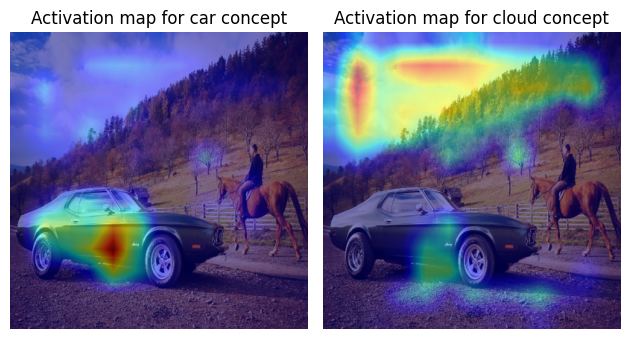

In [4]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)
    
def debug_transform(tensor):
    # print(f'{tensor.shape=}')
    return tensor
    
target_layers = [resnet.encoder.stages[-1].layers[-1]]
targets = [SimilarityToConceptTarget(car_concept_features), SimilarityToConceptTarget(cloud_concept_features)]

with GradCAM(model=model, target_layers=target_layers, reshape_transform=debug_transform) as cam:
    car_grayscale_cam = cam(input_tensor=car_horse_input['pixel_values'].repeat(len(targets),1, 1, 1), targets=targets)
    
fig, axs = plt.subplots(ncols=2)
w = car_grayscale_cam.shape[1]
for i, ax in enumerate(axs):
    ax.imshow(car_horse_img.resize((w,w)))
    ax.imshow(car_grayscale_cam[i, :], cmap='jet', alpha=0.5)
    ax.axis('off')

axs[0].set_title("Activation map for car concept")
axs[1].set_title("Activation map for cloud concept")
plt.tight_layout()
plt.show()

It's significantly worse than the non-huggingface version (see [here](https://jacobgil.github.io/pytorch-gradcam-book/Pixel%20Attribution%20for%20embeddings.html)), why?

Maybe it's because this one isn't using the classification head?

# Now with ViTs

In [5]:
class HFFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(HFFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])

    def forward(self, x):
        # o = self.feature_extractor(x)['last_hidden_state'][:, 0]
        o = self.model(x)['pooler_output']
        # print(f'{o.shape=}')
        return o

# backbone_name = 'facebook/dinov2-base'
# backbone_name = 'google/vit-base-patch16-224'
backbone_name = 'facebook/dinov2-with-registers-base'
n_registers = 4 if 'registers' in backbone_name else 0

# processor = AutoImageProcessor.from_pretrained(backbone_name, use_fast=True, crop_size = {'height': 512, 'width': 512})
processor = AutoImageProcessor.from_pretrained(
    backbone_name,
    use_fast=False,
    do_resize=True,
    size=None if 'vit' in backbone_name else {'shortest_edge': 512},
    do_center_crop=False
)
backbone = AutoModel.from_pretrained(backbone_name)
backbone.eval()

model = HFFeatureExtractor(backbone)

In [6]:
car_img = center_crop(Image.open('/home/ronan/Pictures/Saved Pictures/car.png').convert("RGB"))
cloud_img = center_crop(Image.open('/home/ronan/Pictures/Saved Pictures/clouds.png').convert("RGB"))
car_horse_img = center_crop(Image.open('/home/ronan/Pictures/Saved Pictures/car_and_horse.png').convert("RGB"))

car_input = processor(car_img, return_tensors='pt')
cloud_input = processor(cloud_img, return_tensors='pt')
car_horse_input = processor(car_horse_img, return_tensors='pt')

car_concept_features = model(car_input['pixel_values'])[0]
cloud_concept_features = model(cloud_input['pixel_values'])[0]

model_output.shape=torch.Size([768])
self.features.shape=torch.Size([768])
model_output.shape=torch.Size([768])
self.features.shape=torch.Size([768])
here loss=tensor(0.0876, grad_fn=<AddBackward0>)
reverse hook activating, type(grad)=<class 'torch.Tensor'>
type(layer_grads)=<class 'numpy.ndarray'>
len(grads_list)=1
len(activations_list)=1


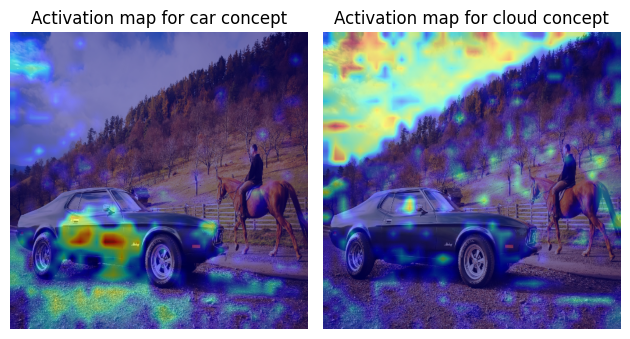

In [7]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        print(f'{model_output.shape=}')
        print(f'{self.features.shape=}')
        loss_fn = torch.nn.CosineSimilarity(dim=0)
        # loss_fn = torch.nn.MSELoss()
        return loss_fn(model_output, self.features)
    
def reshape_transform(tensor):
    w = int(np.sqrt(tensor.shape[1])) # assume all images are sqare
    result = tensor[:, 1+n_registers:  , :].reshape(tensor.size(0), w, w, tensor.size(2))
    result = result.transpose(2, 3).transpose(1, 2)
    return result

if 'vit' in backbone_name:
    target_layer = model.model.encoder.layer[-1].layernorm_before
else:
    target_layer = model.model.encoder.layer[-1].norm1

targets = [SimilarityToConceptTarget(car_concept_features), SimilarityToConceptTarget(cloud_concept_features)]

with GradCAM(model=model, target_layers=[target_layer], reshape_transform=reshape_transform) as cam:
    car_grayscale_cam = cam(input_tensor=car_horse_input['pixel_values'].repeat(len(targets),1, 1, 1), targets=targets)

fig, axs = plt.subplots(ncols=2)
w = car_grayscale_cam.shape[1]
for i, ax in enumerate(axs):
    ax.imshow(car_horse_img.resize((w,w)))
    ax.imshow(car_grayscale_cam[i, :], cmap='jet', alpha=0.5)
    ax.axis('off')

axs[0].set_title("Activation map for car concept")
axs[1].set_title("Activation map for cloud concept")
plt.tight_layout()
plt.show()

Works, but poorly. I suspect something is wrong because things don't work with other `pytorch-grad-cam` methods (i.e. HiResCAM, EigenGradCAM, etc.). It feels like its only barely working.
Try:
- Using the other methods with ViT
- Smoothing out/filtering the output